### import the required librarires

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import os
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
warnings.filterwarnings('ignore')

### Fetch train and test data

In [142]:
df=pd.read_excel(r'train.xlsx')
df_test=pd.read_excel(r'test.xlsx')

In [143]:
df.head()

,Sold To Party,Material,Order Quantity (EA),Plant,First RDD,Net Value,RDD YYYY-MM
0,1001024881,363083,2000,1100,2020-02-06,474.54,2020-02
1,1001024881,363083,7000,1100,2020-02-06,1310.89,2020-02
2,1001024881,364815,45000,1215,2020-01-09,2317.95,2020-01
3,1001024881,363083,10000,1100,2020-02-05,1872.70,2020-02
4,1001024881,366408,1000,1215,2020-01-09,167.59,2020-01


### Preprocess the data before applying to arima model
Here we are doing weekly analysis. There are many combinations of customer and material we are going with the follwing customer.

In [144]:
def data_preprocess(data):
    for r in range(df.shape[0]):
        if df.loc[r,'First RDD']==0:
            df.loc[r,'RDD YW']=0
        else:
            df.loc[r,'RDD YW']=df.loc[r,'First RDD'].strftime('%Y-%V')
    temp=df[(df['Sold To Party']==1001016461) & (df['Material']==292335)]
    t1=temp[['RDD YW', 'Order Quantity (EA)']]
    t1.sort_values(by='RDD YW', inplace=True)
    t1.reset_index(inplace=True, drop=True)
    t1=t1.groupby(by='RDD YW').sum()
    t1.reset_index(inplace=True)
    for r in range(0,t1.shape[0]):
        t1.loc[r,'RDD YW']=datetime.strptime(t1.loc[r,'RDD YW'] + '-1', "%Y-%W-%w")
    t1.set_index('RDD YW', inplace=True)
    return t1

In [145]:
data=data_preprocess(df)
data.shape

(49, 1)

### stationary check

#### Rolling

##### What are rolling window calculations, and why do we care?

Rolling calculations simply apply functions to a fixed width subset of this data (aka a window), indexing one observation each calculation. There are a few common reasons  you may want to use a rolling calculation in time series analysis:

- Measuring the central tendency over time (mean, median)
- Measuring the volatility over time (sd, var)
- Detecting changes in trend (fast vs slow moving averages)
- Measuring a relationship between two time series over time (cor, cov)

A moving average allows us to visualize how an average changes over time, which is very useful in cutting through the noise to detect a trend in a time series dataset.
 In time series analysis, nothing is static. A correlation may exist for a subset of time or an average may vary from one day to the next. 
 
- rolling(4) means we are taking the mean of the last four entries at that particular point of time. same with std
- There are many ways to check stationarity in data and rolling mean and std is one of them.
- Rolling mean is used to check the stationarity. with rolling mean and std we can know the change in average w.r.to time.
- For data to be stationary mean and standard deviation should be constant throughout the timeseries.

In [146]:
def rolling(data):
    mean=data.rolling(12).mean()
    std=data.rolling(12).std()
    return mean,std

In [147]:
def plot_rolling(data,mean,std):
    plt.figure(figsize=(15,4))
    plt.plot(mean,color='red',label='mean')
    plt.plot(std,color='green',label='standard deviation')
    plt.plot(data,color='blue',label='original data')
    plt.legend(loc='best')
    plt.show(block=False)

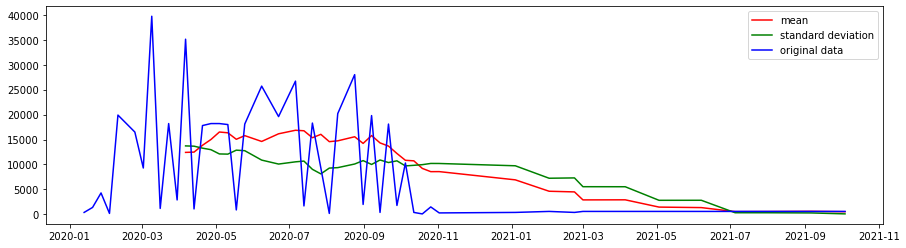

In [148]:
mean,std=rolling(data)
plot_rolling(data,mean,std)

### ADF TEST
ADF (Augmented Dickey Fuller) Test The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

- Null Hypothesis: The series has a unit root (value of a =1)

- Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In our above example, the test statistic > critical value, which implies that the series is not stationary. This confirms our original observation which we initially saw in the visual test.

https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/#:~:text=Test%20for%20stationarity%3A%20If%20the,the%20series%20is%20not%20stationary).

In [149]:
def stationary_test(data):
    result=adfuller(data)
    print(result[1])
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        res='stationary'
        return res
        #print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        res='non-stationary'
        return res
        #print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
#stationary_test

In [150]:
stationary_test(data)

0.30167309600275494
ADF Test Statistic : -1.9660085322400667
p-value : 0.30167309600275494
#Lags Used : 2
Number of Observations Used : 46


'non-stationary'

### Transform data to make it stationary
One way to transform non-stationary data is applying log.

In [151]:
def log(data):
    log_data=np.log(log_data)
    return log_data

In [152]:
log_data=np.log(data)
stationary_test(log_data)

0.8248984980697573
ADF Test Statistic : -0.7800974639658383
p-value : 0.8248984980697573
#Lags Used : 4
Number of Observations Used : 44


'non-stationary'

### Differencing

The second (and most important) step in fitting an ARIMA model is the determination of the order of differencing needed to stationarize the series. Normally, the correct amount of differencing is the lowest order of differencing that yields a time series which fluctuates around a well-defined mean value and whose autocorrelation function (ACF) plot decays fairly rapidly to zero, either from above or below. If the series still exhibits a long-term trend, or otherwise lacks a tendency to return to its mean value, or if its autocorrelations are are positive out to a high number of lags (e.g., 10 or more), then it needs a higher order of differencing.

In [153]:
def diff_data(data):
    log_diff=log_data-log_data.shift(1)
    return log_diff

In [154]:
log_diff=diff_data(log_data)
stationary_test(log_diff[1:])

1.9860170519098638e-07
ADF Test Statistic : -5.966110135893695
p-value : 1.9860170519098638e-07
#Lags Used : 3
Number of Observations Used : 44


'stationary'

In [155]:
train=log_data[:30]
test=log_data[30:]

### Build Models

In [156]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(log_data, start_p=0, start_q=0,
                           max_p=5, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=214.644, Time=2.68 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=191.863, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=185.912, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=212.645, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=184.165, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=186.020, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=186.060, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=184.191, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=185.928, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=186.353, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=182.273, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=184.226, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=189.863, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=184.096, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=184.1

In [157]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

### Evaluate the model on test data

In [158]:
future_forecast = stepwise_model.predict(n_periods=19)

<AxesSubplot:xlabel='RDD YW'>

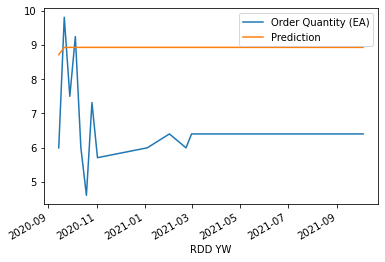

In [159]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot()

In [160]:
future_forecast

,Prediction
RDD YW,
2020-09-14,8.710034
2020-09-21,8.924159
2020-09-28,8.924159
2020-10-05,8.924159
2020-10-12,8.924159
2020-10-19,8.924159
2020-10-26,8.924159
2020-11-02,8.924159
2021-01-04,8.924159


In [162]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(test['Order Quantity (EA)'],future_forecast))

6.5899223364170965
